<a href="https://colab.research.google.com/github/DerekLiu35/ChessCV/blob/main/Chess_object_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chess Object detection

In [ ]:
import numpy as np
import os
import re
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from random import shuffle

import warnings
warnings.filterwarnings('ignore')

In [ ]:
import os
from pathlib import Path
import shutil
import sys
import subprocess
from subprocess import PIPE, Popen


repo = "ChessCV"

branch = "main"

def _go():
    # create the repo and cd into it
    repo_root = Path("/") / "content" / repo
    os.chdir(repo_root.parent)

    shutil.rmtree(repo_root, ignore_errors=True)

    # clone repo
    url = "https://github.com/DerekLiu35/ChessCV.git"
    subprocess.run(  # run git clone
    ["git", "clone", url], check=True)

    os.chdir(repo_root)

    _install_dependencies_colab()

def _install_dependencies_colab():
    !pip install --quiet -r requirements/prod.in

    # run a series of commands with pipes to pip install the dev requirements
    !sed 1d requirements/dev.in | grep -v '#' | xargs pip install --quiet

    # reset pkg_resources list of requirements so gradio can ifner its version correctly
    import pkg_resources

    pkg_resources._initialize_master_working_set()

In [ ]:
run = True
if run:
    # path management for Python
    pythonpath, = !echo $PYTHONPATH
    if "." not in pythonpath.split(":"):
        pythonpath = ".:" + pythonpath
        %env PYTHONPATH={pythonpath}
        !echo $PYTHONPATH

    # get both Colab and local notebooks into the same state

    _go()

    # allow "hot-reloading" of modules
    %load_ext autoreload
    %autoreload 2
    # needed for inline plots in some contexts
    %matplotlib inline

!pwd
%ls

env: PYTHONPATH=.:/env/python
.:/env/python
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 681.2/681.2 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.0/235.0 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.1/20.1 MB 40.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 47.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 451.7/451.7 kB 41.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.8/293.8 kB 30.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.2/66.2 kB 7.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.2/298.2 kB 36.0 MB/

# Download Dataset

In [ ]:
from google.colab import files

files.upload() # upload kaggle api token

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"derekzliu","key":"a29892d6cd0a3f5febf9a51f5c74200e"}'}

In [ ]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d koryakinp/chess-positions

100% 4.01G/4.01G [02:25<00:00, 37.2MB/s]
100% 4.01G/4.01G [02:25<00:00, 29.6MB/s]


In [ ]:
from image_to_fen.data import ChessDataModule
dm = ChessDataModule()
dm.prepare_data()
dm.setup()
dm

Extracting IAM data


Chess Positions Dataset

In [ ]:
xs, ys = next(iter(dm.train_dataloader()))

{'boxes': tensor([[100.,  25., 125.,  50.],
        [150.,  25., 175.,  50.],
        [ 25.,  50.,  50.,  75.],
        [ 50.,  75.,  75., 100.],
        [125.,  75., 150., 100.],
        [ 75., 100., 100., 125.],
        [ 50., 150.,  75., 175.],
        [125., 150., 150., 175.],
        [100., 175., 125., 200.]]), 'labels': tensor([ 1,  9,  7,  5,  4,  2, 11, 11,  8]), 'image_id': tensor([851]), 'area': tensor([625., 625., 625., 625., 625., 625., 625., 625., 625.]), 'iscrowd': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0])}


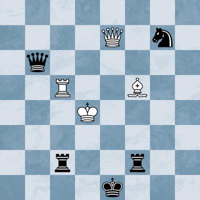

In [ ]:
import random

import wandb

idx = random.randint(0, len(xs))

print(ys[idx])
wandb.Image(xs[idx]).image

# Helper functions

In [ ]:
root = Path("README.md").resolve().parents[0]
root

PosixPath('/content/ChessCV')

In [ ]:
import image_to_fen.data.util as util
train = list(sorted(os.listdir(os.path.join(root, "train"))))

piece_symbols = 'prbnkqPRBNKQ'

In [ ]:
train[1]

'1B1B1N2-1r6-n2R2k1-7b-1B6-8-8-Kn6.jpeg'

In [ ]:
def fen_from_filename(filename):
  base = os.path.basename(filename)
  return os.path.splitext(base)[0]

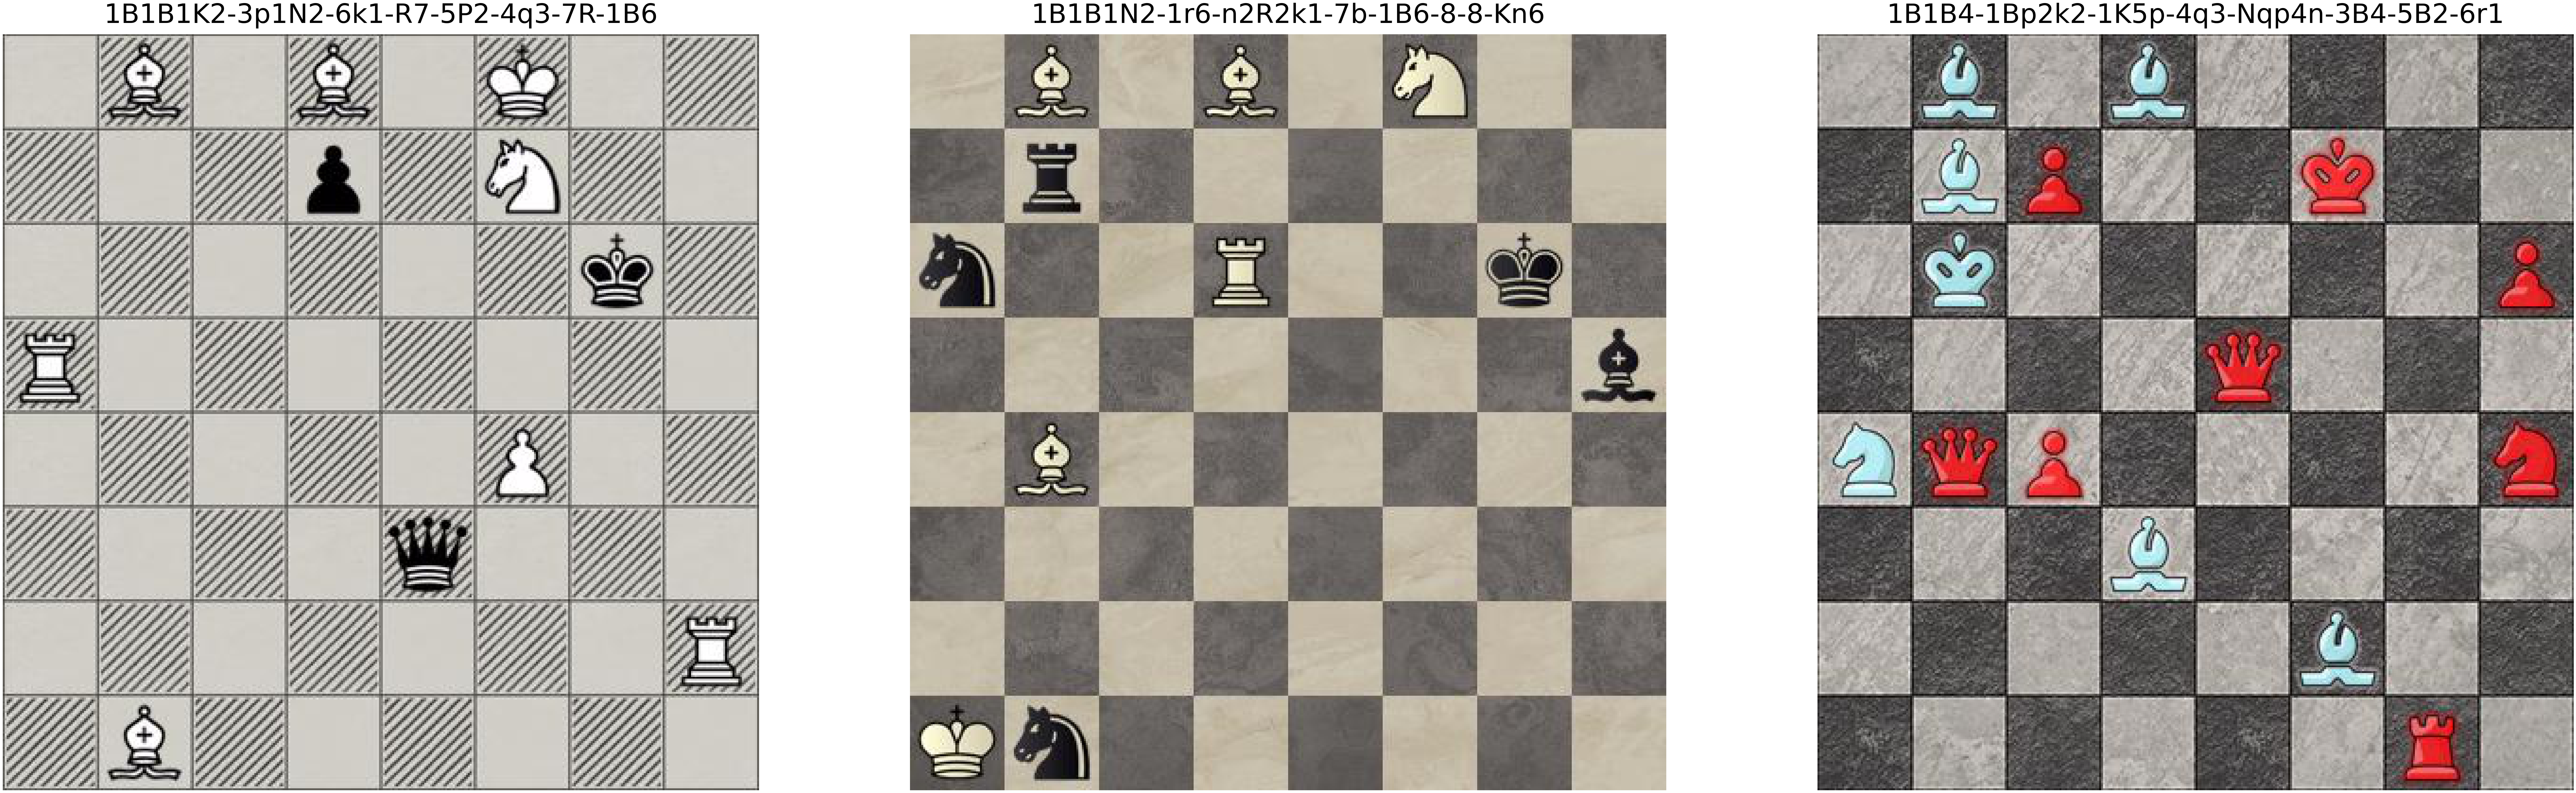

In [ ]:
f, axarr = plt.subplots(1,3, figsize=(120, 120))

for i in range(0,3):
    axarr[i].set_title(util.fen_from_filename(os.path.join(root, "train", train[i])), fontsize=70, pad=30)
    axarr[i].imshow(mpimg.imread(os.path.join(root, "train", train[i])))
    axarr[i].axis('off')

In [ ]:
def onehot_from_fen(fen):
    eye = np.eye(13)
    output = np.empty((0, 13))
    fen = re.sub('[-]', '', fen)

    for char in fen:
        if(char in '12345678'):
            output = np.append(
              output, np.tile(eye[12], (int(char), 1)), axis=0)
        else:
            idx = piece_symbols.index(char)
            output = np.append(output, eye[idx].reshape((1, 13)), axis=0)

    return output

def fen_from_onehot(one_hot):
    output = ''
    for j in range(8):
        for i in range(8):
            idx = np.where(one_hot[j*8 + i]==1)[0][0]
            if(idx == 12):
                output += ' '
            else:
                output += piece_symbols[idx]
        if(j != 7):
            output += '-'

    for i in range(8, 0, -1):
        output = output.replace(' ' * i, str(i))

    return output

In [ ]:
downsample_size = 200
square_size = int(downsample_size/8)
piece_symbols = 'prbnkqPRBNKQ'
def boxes_labels_from_fen(fen):
    boxes = np.empty((0, 4))
    labels = []
    x = 0
    y = 0
    for char in fen:
        if(char in '12345678'):
          x += int(char) * square_size
        elif char == '-':
          y += square_size
          x = 0
        else:
            boxes = np.append(boxes, [[x, y, x + square_size, y + square_size]], axis = 0)
            x += square_size
            idx = piece_symbols.index(char)
            labels.append(12 - idx)

    return boxes, labels

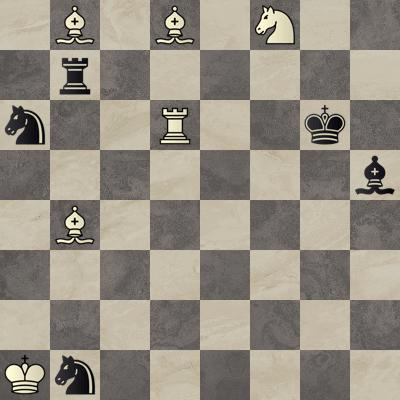

In [ ]:
from PIL import Image
img = Image.open(os.path.join(root, "train", train[1])).convert("RGB")
img

In [ ]:
target, labels = util.boxes_labels_from_fen(util.fen_from_filename(train[1]))
print(target)
print(labels)


[[ 25.   0.  50.  25.]
 [ 75.   0. 100.  25.]
 [125.   0. 150.  25.]
 [ 25.  25.  50.  50.]
 [  0.  50.  25.  75.]
 [ 75.  50. 100.  75.]
 [150.  50. 175.  75.]
 [175.  75. 200. 100.]
 [ 25. 100.  50. 125.]
 [  0. 175.  25. 200.]
 [ 25. 175.  50. 200.]]
[4, 4, 3, 11, 9, 5, 8, 10, 4, 2, 9]


# Visualization

In [ ]:
from image_to_fen.data.util import ChessDataset
# check dataset
root = "/content/ChessCV"
dataset = ChessDataset(root)
print('length of dataset = ', len(dataset), '\n')

# getting the image and target for a test index.  Feel free to change the index.
dataset[0]
#print(img.shape, '\n',target)


length of dataset =  1000 



(<PIL.Image.Image image mode=RGB size=200x200>,
 {'boxes': tensor([[175.,   0., 200.,  25.],
          [ 50.,  25.,  75.,  50.],
          [150.,  25., 175.,  50.],
          [175.,  50., 200.,  75.],
          [ 50., 100.,  75., 125.],
          [ 50., 150.,  75., 175.],
          [ 50., 175.,  75., 200.],
          [125., 175., 150., 200.]]),
  'labels': tensor([11, 10, 12,  8,  2,  7,  4, 10]),
  'image_id': tensor([0]),
  'area': tensor([625., 625., 625., 625., 625., 625., 625., 625.]),
  'iscrowd': tensor([0, 0, 0, 0, 0, 0, 0, 0])})

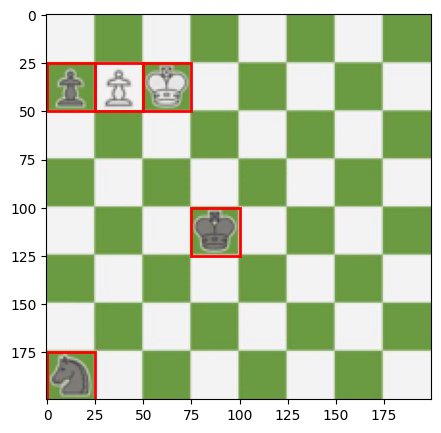

In [ ]:
# Function to visualize bounding boxes in the image
import matplotlib.patches as patches

def plot_img_bbox(img, target):
    # plot the image and bboxes
    # Bounding boxes are defined as follows: x-min y-min width height
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(5,5)
    a.imshow(img)
    for box in (target['boxes']):
        x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = patches.Rectangle((x, y),
                                 width, height,
                                 linewidth = 2,
                                 edgecolor = 'r',
                                 facecolor = 'none')

        # Draw the bounding box on top of the image
        a.add_patch(rect)
    plt.show()

# plotting the image with bboxes. Feel free to change the index
img, target = dataset[25]
plot_img_bbox(img, target)


# Choose Model

In [ ]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

fatal: destination path 'vision' already exists and is not an empty directory.


In [ ]:
import torchvision
from torchvision import transforms as torchtrans
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

def get_object_detection_model(num_classes):

    # load a model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [ ]:
import torch
import utils
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
dataset = ChessDataset('/content/ChessCV', transforms=get_transform(train=True))
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)
# data_loader = dm.train_dataloader()
# For Training
images,targets = next(iter(data_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
output = model(images,targets)   # Returns losses and detections
output
# For inference
# model.eval()
# x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
# predictions = model(x)           # Returns predictions


Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:03<00:00, 51.6MB/s]


{'loss_classifier': tensor(2.5954, grad_fn=<NllLossBackward0>),
 'loss_box_reg': tensor(0.4381, grad_fn=<DivBackward0>),
 'loss_objectness': tensor(0.7200, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>),
 'loss_rpn_box_reg': tensor(0.0134, grad_fn=<DivBackward0>)}

In [ ]:
# use our dataset and defined transformations
dataset = ChessDataset('/content/ChessCV', transforms=get_transform(train=True))
dataset_test = ChessDataset('/content/ChessCV', transforms=get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=16, shuffle=True, num_workers=2,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=2, shuffle=False, num_workers=2,
    collate_fn=utils.collate_fn)

In [ ]:
# to train on gpu if selected.
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')


num_classes = 13

# get the model using our helper function
model = get_object_detection_model(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [ ]:
torch.cuda.empty_cache()

In [ ]:
import gc
gc.collect()

4052

In [ ]:
!nvidia-smi

Wed Jul 12 16:50:00 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    28W /  70W |    273MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Train Model

In [ ]:
# let's train it for 10 epochs
from engine import train_one_epoch, evaluate
from torch.optim.lr_scheduler import StepLR
num_epochs = 5
print_freq=10
scaler = None

for epoch in range(num_epochs):
    # training for one epoch
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

Epoch: [0]  [ 0/60]  eta: 0:03:50  lr: 0.000090  loss: 0.7994 (0.7994)  loss_classifier: 0.5580 (0.5580)  loss_box_reg: 0.2386 (0.2386)  loss_objectness: 0.0006 (0.0006)  loss_rpn_box_reg: 0.0021 (0.0021)  time: 3.8453  data: 1.0084  max mem: 11451
Epoch: [0]  [10/60]  eta: 0:02:25  lr: 0.000936  loss: 0.7877 (0.7875)  loss_classifier: 0.5544 (0.5537)  loss_box_reg: 0.2328 (0.2315)  loss_objectness: 0.0004 (0.0004)  loss_rpn_box_reg: 0.0019 (0.0019)  time: 2.9038  data: 0.1343  max mem: 11452
Epoch: [0]  [20/60]  eta: 0:01:53  lr: 0.001783  loss: 0.7556 (0.7592)  loss_classifier: 0.5350 (0.5389)  loss_box_reg: 0.2132 (0.2180)  loss_objectness: 0.0004 (0.0005)  loss_rpn_box_reg: 0.0018 (0.0018)  time: 2.7982  data: 0.0484  max mem: 11452
Epoch: [0]  [30/60]  eta: 0:01:24  lr: 0.002629  loss: 0.6924 (0.7205)  loss_classifier: 0.5013 (0.5129)  loss_box_reg: 0.1885 (0.2054)  loss_objectness: 0.0004 (0.0005)  loss_rpn_box_reg: 0.0017 (0.0017)  time: 2.7591  data: 0.0496  max mem: 11452
Epoc

In [ ]:
torch.save(model.state_dict(), 'chess_params')

In [ ]:
import torch
num_classes = 13
model = get_object_detection_model(num_classes)
model.load_state_dict(torch.load('/content/chess_params'))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

In [ ]:
# the function takes the original prediction and the iou threshold.

def apply_nms(orig_prediction, iou_thresh=0.3):

    # torchvision returns the indices of the bboxes to keep
    keep = torchvision.ops.nms(orig_prediction['boxes'], orig_prediction['scores'], iou_thresh)

    final_prediction = orig_prediction
    final_prediction['boxes'] = final_prediction['boxes'][keep]
    final_prediction['scores'] = final_prediction['scores'][keep]
    final_prediction['labels'] = final_prediction['labels'][keep]

    return final_prediction

# function to convert a torchtensor back to PIL image
def torch_to_pil(img):
    return torchtrans.ToPILImage()(img).convert('RGB')

In [ ]:
import torch
device = torch.device('cpu')
# pick one image from the test set
img, target = dataset_test[5]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])[0]

print('predicted #boxes: ', len(prediction['labels']))
print('real #boxes: ', len(target['labels']))


NameError: ignored

EXPECTED OUTPUT


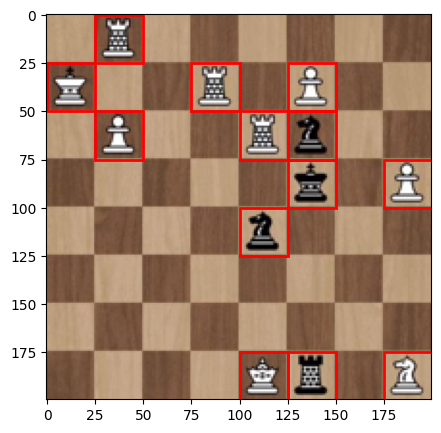

In [ ]:
print('EXPECTED OUTPUT')
plot_img_bbox(torch_to_pil(img), target)

MODEL OUTPUT


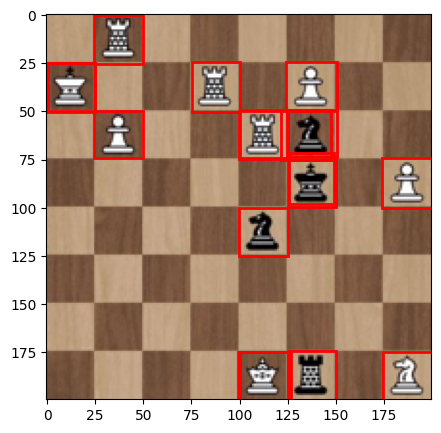

In [ ]:
prediction['boxes'] = prediction['boxes'].cpu()
print('MODEL OUTPUT')
plot_img_bbox(torch_to_pil(img), prediction)


NMS APPLIED MODEL OUTPUT


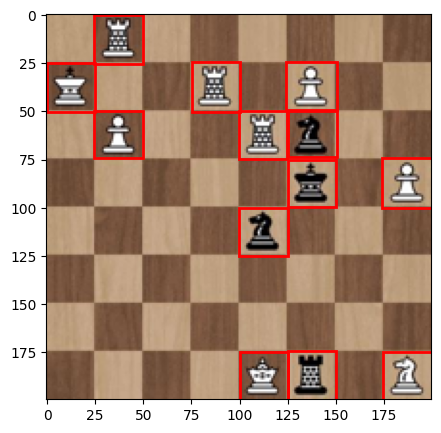

tensor([[ 99.6557,  99.8857, 125.0389, 124.9996],
        [ 75.0781,  24.1514, 100.3022,  50.1990],
        [174.6980, 174.7782, 199.8190, 200.0000],
        [ 24.4833,   0.0000,  49.9269,  25.1340],
        [ 99.7776,  49.8347, 124.8756,  74.5829],
        [124.9236, 174.6541, 150.2392, 200.0000],
        [125.0564,  75.1130, 150.0682,  99.6397],
        [ 24.1461,  49.6411,  50.0689,  74.2494],
        [173.8381,  74.2318, 200.0000, 100.0937],
        [124.1703,  24.1472, 150.3893,  49.4245],
        [125.2257,  49.8568, 150.5789,  73.8648],
        [  0.0000,  24.8376,  24.7483,  50.1540],
        [100.0723, 174.9081, 124.9220, 200.0000],
        [199.9793,  73.5372, 199.9999,  76.6599]])


In [ ]:
prediction['boxes'] = prediction['boxes'].cuda()
prediction['scores'] = prediction['scores'].cuda()
prediction['labels'] = prediction['labels'].cuda()
nms_prediction = apply_nms(prediction, iou_thresh=0.2)
prediction['boxes'] = prediction['boxes'].cpu()
print('NMS APPLIED MODEL OUTPUT')
plot_img_bbox(torch_to_pil(img), nms_prediction)
print(nms_prediction['boxes'])


In [ ]:
def boxes_labels_to_fen(boxes, labels):
  boxes = torch.round(boxes / 25) * 25
  eye = np.eye(13)
  one_hot = onehot_from_fen("8-8-8-8-8-8-8-8")
  for i, box in enumerate(boxes):
    x = box[0]
    y = box[1]
    ind = int((x / square_size) + (y / square_size) * 8)
    if (ind >= 64):
      continue
      print(ind)
    one_hot[ind] = eye[12 - labels[i]].reshape((1, 13)).astype(int)
  return fen_from_onehot(one_hot)

1R6-K2R1P2-1P2Rn2-5k1P-b3n3-8-8-4Qr1N


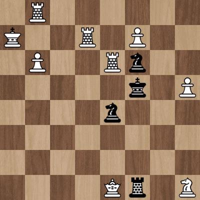

In [ ]:
one = boxes_labels_to_fen(nms_prediction['boxes'], nms_prediction['labels'].cpu())
print(one)
torch_to_pil(img)

# Evaluate

In [ ]:
import glob
test = glob.glob("/content/ChessCV/test/*.jpeg")

shuffle(test)

test = test[:50]
len(test)

50

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
model.eval()
with torch.no_grad():
    res = []
    for i in range(len(test)):
      img = Image.open(test[i]).resize((downsample_size, downsample_size))
      img = torchtrans.PILToTensor()(img)/255
      prediction = model([img.to(device)])[0]
      nms_prediction = apply_nms(prediction, iou_thresh=0.2)
      res.append((nms_prediction['boxes'], nms_prediction['labels']))
len(res)

50

In [ ]:
boxes, labels = res[0]
boxes_labels_to_fen(boxes, labels)

'Qr6-1p2b2k-KP5n-5N2-N3P2N-8-2pR4-8'

In [ ]:
res = res[:1000]
[boxes_labels_to_fen(boxes, labels) for boxes, labels in res]

['Qr6-1p2b2k-KP5n-5N2-N3P2N-8-2pR4-8',
 '1br1K3-R7-4P3-8-6k1-8-8-8',
 '8-5k1B-1b6-N3R3-8-1K3n1P-5P2-4q2N',
 '4q3-5p1q-5b2-K7-2rB4-k4N1N-8-8',
 '7B-N1p4B-8-7R-2Kp1r2-8-6k1-4r3',
 'N1RN2k1-8-7R-4p3-8-8-3K4-4nr2',
 '1q3N2-6n1-1rBk4-6b1-1np5-1b2b3-8-2K2N2',
 '8-5P2-5K2-N1n5-3p4-6k1-3Bp1np-N6q',
 'q7-8-5bp1-2K5-3P4-8-2k5-8',
 'K3b3-8-8-p2p3p-1k6-1B6-1b6-8',
 '4b1K1-8-3P1P2-2b4k-4P3-r1N5-3n2P1-4B3',
 '4r1r1-8-1Q6-1R2K3-5Nn1-5r2-b2nk3-4R3',
 '8-5r2-5k2-8-R7-1K2p3-1R6-8',
 '8-3p1k2-K7-4N1n1-8-8-6r1-5N2',
 '1n2b3-2Np3k-8-p2R1N2-8-8-1PP1PR2-1Kb3B1',
 '1K6-8-1r2n2P-B3N3-3k4-4N3-4P3-5Q2',
 '8-4K3-8-8-1p5N-R4k2-4nBP1-5N2',
 '1b1b4-1N5r-1P1p3B-8-3KP3-3P2k1-3PB3-1N6',
 '8-6k1-8-8-K1P2B2-8-6N1-B7',
 '5QQ1-2P3K1-5R2-R7-1Rb2B2-7r-7N-2q3Rk',
 '3K4-B1p1rr2-8-3k4-5n1r-4R3-N5q1-B7',
 'r5r1-Kp3r2-8-3P2B1-2kPN3-N2r4-rR6-8',
 'K1q3n1-8-p5N1-8-3R1Q2-5k2-8-3N4',
 '8-1N2kp2-6n1-b7-1K6-2Q5-3R4-1R2n3',
 '2N1R3-6KB-8-3R4-2R1B3-8-4b1k1-2b5',
 '2B5-4N3-1K5p-7q-3k4-P4q1p-8-r2b3B',
 '1Qr5-8-2N1p3-8-3p3B-b1K2Q2-2Np1kb1-6

In [ ]:
pred_fens = np.array([boxes_labels_to_fen(boxes, labels) for (boxes, labels) in res])
test_fens = np.array([fen_from_filename(fn) for fn in test[:len(res)]])

final_accuracy = (pred_fens == test_fens).astype(float).mean()

print("Final Accuracy: {:1.5f}%".format(final_accuracy))

Final Accuracy: 0.96000%


b4bb1-2K3R1-B1P5-3Q4-1p6-3k2p1-6R1-8


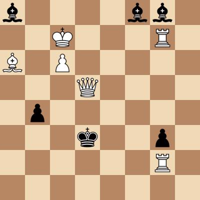

In [ ]:
print(pred_fens[29])
Image.open(test[29]).resize((downsample_size, downsample_size))


In [ ]:
def display_with_predicted_fen(idx):
    fen = pred_fens[idx]
    imgplot = plt.imshow(mpimg.imread(test[idx]))
    plt.axis('off')
    plt.title(fen)
    plt.show()

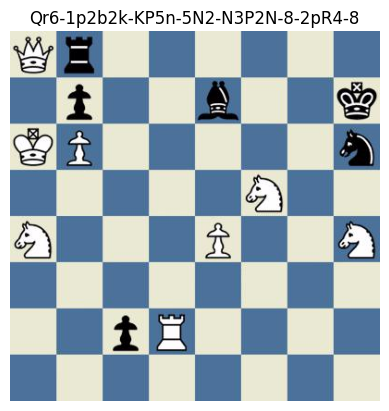

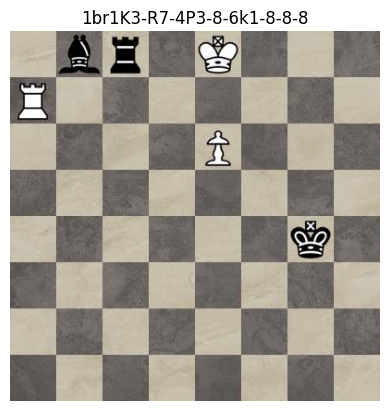

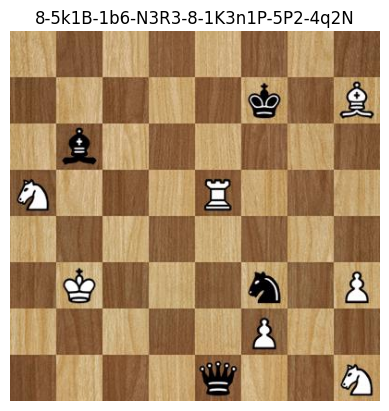

In [ ]:
display_with_predicted_fen(0)
display_with_predicted_fen(1)
display_with_predicted_fen(2)

# Compiling Model

In [ ]:
model.eval()
scripted_model = torch.jit.script(model)

In [ ]:
torch.jit.save(scripted_model, 'model.pt')

In [ ]:
scripted_model

RecursiveScriptModule(
  original_name=FasterRCNN
  (transform): RecursiveScriptModule(original_name=GeneralizedRCNNTransform)
  (backbone): RecursiveScriptModule(
    original_name=BackboneWithFPN
    (body): RecursiveScriptModule(
      original_name=IntermediateLayerGetter
      (conv1): RecursiveScriptModule(original_name=Conv2d)
      (bn1): RecursiveScriptModule(original_name=FrozenBatchNorm2d)
      (relu): RecursiveScriptModule(original_name=ReLU)
      (maxpool): RecursiveScriptModule(original_name=MaxPool2d)
      (layer1): RecursiveScriptModule(
        original_name=Sequential
        (0): RecursiveScriptModule(
          original_name=Bottleneck
          (conv1): RecursiveScriptModule(original_name=Conv2d)
          (bn1): RecursiveScriptModule(original_name=FrozenBatchNorm2d)
          (conv2): RecursiveScriptModule(original_name=Conv2d)
          (bn2): RecursiveScriptModule(original_name=FrozenBatchNorm2d)
          (conv3): RecursiveScriptModule(original_name=Conv2d)
